# Syntax

## scikit-learn syntax

    from sklearn.module import Model

    model = Model()

    model.fit(X, y)predictions = model.predict(X_new)

    print(predictions)

# Regression mechanics

## Simple Linear Regression

### Model Equation

y = ax + b 

- **y**: target
- **x**: single feature
- **a, b**: parameters/coefficients of the model - slope, intercept

### Choosing Parameters (a and b)

1. **Define an error function for any given line.**
2. **Choose the line that minimizes the error function.**

### Error Function

- Also known as the loss function or cost function.


## Customer Lifetime Value 

CVL is a business metric indicating the amount of money customers will spend on a company's products/services over time. 

### Calculate CLV

CLV = Customer Value × Average Customer Lifespan

- Customer Value: Average purchase frequency multiplied by the average purchase value.
- Average Customer Lifespan: The average length of time a customer continues buying from you.

### CLV Calculation Levels

- Company Level: Average CLV across all customers.
- Customer Segment Level: CLV of distinct groups within your customer base.
- Individual Level: CLV of each individual custome

# Load Data

The dataset in this notebook is archived from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/352/online+retail).

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail."

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


# Data Clean-up

## Preparing columns for modeling 

### Negative values 

The negative values in the 'Quantity' column denote quantity of products where transactions were canceled.

In [4]:
df.loc[df['Quantity'] <= 0].shape 

(10624, 8)

In [5]:
df = df.loc[df['Quantity'] > 0]

### Missing Data
There are some null values in CustomerID column. We will remove them from our dataset as ML model does not accept null values. 

In [6]:
df[df.isna().any(axis=1)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [7]:
df = df[pd.notnull(df['CustomerID'])]

In [8]:
df.shape

(397924, 8)

### Incomplete Data
The transactions were from 1st Dec, 2010 to 9th Dec, 2011. The data in December 2011 was not fully recorded. We will delete them to avoid errors in our predictive model. 

In [9]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [10]:
df.shape

(380620, 8)

Add 'Sales' column (total purchase amount for each transaction) by multiplying 'Quantity' to 'UnitPrice'. 

In [11]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [12]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Row Granularity

The dataframe neeed to be reshaped so that each row represents a customerID. 

In [13]:
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({ 'Sales': 'sum', 'InvoiceDate': 'max'})
orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]

## Feature Engineering
To calculate CLV, we must engineer those features: 
- `purchase_frequency` : average #days between purchases for each customer
- `purchase_duration` : total duration in days between a customer's first and last transaction
- `avg_purchase` : average amount spent per transaction
- `count` : total number of transactions in the whole period 

In [14]:
def groupby_mean(x): 
    return x.mean()
def groupby_count(x): 
    return x.count()
def purchase_duration(x):
    return (x.max() - x.min()).days
def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg' 
groupby_count.__name__ = 'count' 
purchase_duration.__name__ = 'purchase_duration' 
avg_frequency.__name__ = 'purchase_frequency'

In [15]:
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': ['min', 'max', 'sum', groupby_mean, groupby_count], 
    'InvoiceDate': ['min', 'max', purchase_duration, avg_frequency]
})

In [16]:
summary_df.head()

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000     1   
12347.0       382.52   1294.32   4085.18    680.863333     6   
12348.0       227.44    892.80   1797.24    449.310000     4   
12349.0      1757.55   1757.55   1757.55   1757.550000     1   
12350.0       334.40    334.40    334.40    334.400000     1   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   

                               
           purchase_frequency  
CustomerID                     
12346.0                   0.0  
12347.0                  54.5  
12348.0                  70.5  
12349.0                   0.0  
12350.0                   0.0

In [17]:
summary_df.columns

MultiIndex([(      'Sales',                'min'),
            (      'Sales',                'max'),
            (      'Sales',                'sum'),
            (      'Sales',                'avg'),
            (      'Sales',              'count'),
            ('InvoiceDate',                'min'),
            ('InvoiceDate',                'max'),
            ('InvoiceDate',  'purchase_duration'),
            ('InvoiceDate', 'purchase_frequency')],
           )

In [18]:
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df.reset_index(inplace=True)

# Display the DataFrame to check the new column names
summary_df.head()

,CustomerID,Sales_min,Sales_max,Sales_sum,Sales_avg,Sales_count,InvoiceDate_min,InvoiceDate_max,InvoiceDate_purchase_duration,InvoiceDate_purchase_frequency
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0


Customers with only one transaction in the period are excluded during the EDA step to focus on visualizing customers with retention. 

In [19]:
summary_df = summary_df.loc[summary_df['InvoiceDate_purchase_duration'] > 0]

In [20]:
summary_df.shape

(2692, 10)

# EDA

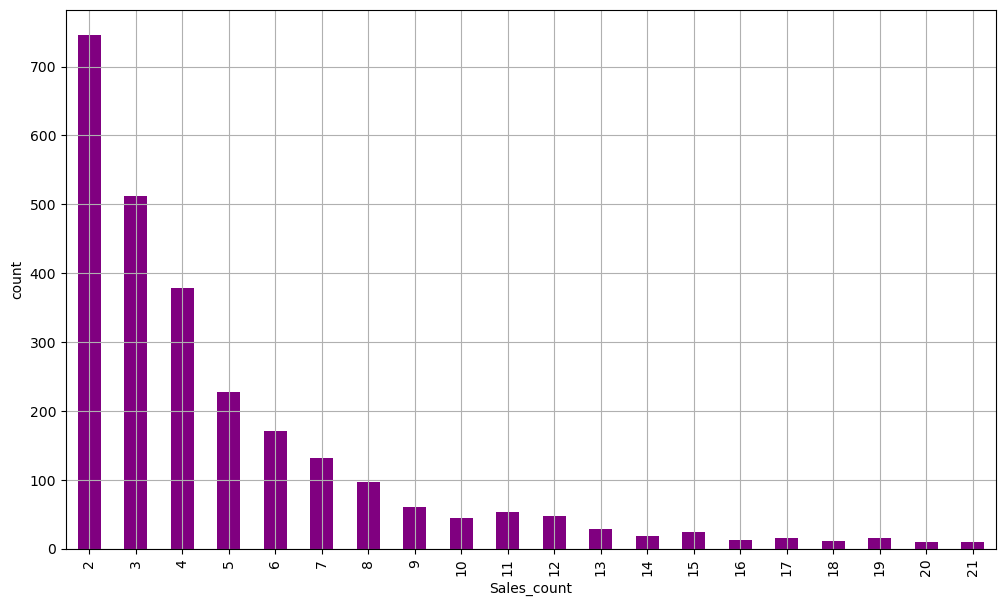

In [21]:
import matplotlib.pyplot as plt

# Group by the 'Sales_count' column and 
# count values in other columns for each group
ax = summary_df.groupby('Sales_count').count()['Sales_avg'][:20].plot(
    kind='bar',
    color='purple', 
    figsize=(12,7),     
    grid=True
)
ax.set_ylabel('count')
plt.show()

Remark: Most customers conducted fewer than nine transactions. 

# Data Pre-processing

## Data Prep

We will build a prediction model for CLV over a 3-month period. To start, we divide the time series data into 3-month blocks. 

In [22]:
# Group data by 'CustomerID' and 3-month time interval
data_df = orders_df.reset_index().groupby([ 'CustomerID', pd.Grouper(key='InvoiceDate', freq='3M')])

In [23]:
# Aggregate functions for the 'Sales' column
agg_functions = {
    'Sales': [
        ('sum_sales', 'sum'),        # Sum of sales
        ('mean_sales', groupby_mean),# Mean of sales
        ('count_sales', groupby_count)# Count of sales
    ]
}

In [24]:
data_df = data_df.agg(agg_functions)
data_df

Sales                          
                       sum_sales    mean_sales count_sales
CustomerID InvoiceDate                                    
12346.0    2011-03-31   77183.60  77183.600000           1
12347.0    2010-12-31     711.79    711.790000           1
           2011-03-31     475.39    475.390000           1
           2011-06-30    1018.77    509.385000           2
           2011-09-30     584.91    584.910000           1
...                          ...           ...         ...
18283.0    2011-06-30     524.68    131.170000           4
           2011-09-30     278.09     92.696667           3
           2011-12-31     766.21    153.242000           5
18287.0    2011-06-30     765.28    765.280000           1
           2011-12-31    1072.00    536.000000           2

[9220 rows x 3 columns]

In [25]:
data_df.columns = ['_'.join(col).strip() for col in data_df.columns]

In [26]:
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,Sales_sum_sales,Sales_mean_sales,Sales_count_sales
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


Label the 3-month time intervals as follows: M_1 for the period ending on 31st December 2011, M_2 for the period ending on 30th September 2011, and so forth, with smaller n indicating more recent intervals.

In [27]:
# create a dictionay 
date_month_map = {
    str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True) )
}

In [28]:
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])

In [29]:
date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [30]:
data_df.columns = [col.replace('Sales_', '') for col in data_df.columns]
data_df.head()

,CustomerID,InvoiceDate,sum_sales,mean_sales,count_sales,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2


## Building Sample Set

The last 3 months in yeat 2011 will be the test set. The remaining time blocks are for training. 

In [31]:
clv_freq = '3M'

First, we extract the features from the dataset. 

In [32]:
# Remove M_1 time blocks
features_df = pd.pivot_table( 
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sum_sales', 'mean_sales', 'count_sales'], 
    columns='M',
index='CustomerID'
)
features_df.head()

count_sales                mean_sales                              \
M                  M_2  M_3  M_4  M_5        M_2      M_3        M_4     M_5   
CustomerID                                                                     
12346.0            NaN  NaN  1.0  NaN        NaN      NaN  77183.600     NaN   
12347.0            1.0  2.0  1.0  1.0     584.91  509.385    475.390  711.79   
12348.0            1.0  1.0  1.0  1.0     310.00  367.000    227.440  892.80   
12350.0            NaN  NaN  1.0  NaN        NaN      NaN    334.400     NaN   
12352.0            2.0  NaN  5.0  NaN     316.25      NaN    312.362     NaN   

           sum_sales                             
M                M_2      M_3       M_4     M_5  
CustomerID                                       
12346.0          NaN      NaN  77183.60     NaN  
12347.0       584.91  1018.77    475.39  711.79  
12348.0       310.00   367.00    227.44  892.80  
12350.0          NaN      NaN    334.40     NaN  
12352.0       632.50      NaN   1561.81     NaN

In [33]:
features_df.columns = ['_'.join(col).strip() for col in features_df.columns]
features_df.head()

,count_sales_M_2,count_sales_M_3,count_sales_M_4,count_sales_M_5,mean_sales_M_2,mean_sales_M_3,mean_sales_M_4,mean_sales_M_5,sum_sales_M_2,sum_sales_M_3,sum_sales_M_4,sum_sales_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,1.0,NaN,NaN,NaN,77183.600,NaN,NaN,NaN,77183.60,NaN
12347.0,1.0,2.0,1.0,1.0,584.91,509.385,475.390,711.79,584.91,1018.77,475.39,711.79
12348.0,1.0,1.0,1.0,1.0,310.00,367.000,227.440,892.80,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,1.0,NaN,NaN,NaN,334.400,NaN,NaN,NaN,334.40,NaN
12352.0,2.0,NaN,5.0,NaN,316.25,NaN,312.362,NaN,632.50,NaN,1561.81,NaN


In [34]:
# fill out the missing values with 0
features_df = features_df.fillna(0)

Second, we merge the CLV calculated for the last 3 months in year 2011 (M_1) from data_df with the features set to create a sample set. 

In [35]:
M1_df = data_df.loc[ 
    data_df['M'] == 'M_1', 
    ['CustomerID', 'sum_sales']
]

In [36]:
# rename the column 'sum_sales' to 'CLV_3M'
# reason: 'sum_sales' denote the total amount spent by a customer over the observed period (3 months)
M1_df.columns = ['CustomerID', 'CLV_'+ clv_freq]

In [37]:
M1_df.head()

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67


In [38]:
sample_set_df = features_df.merge(
    M1_df,
    left_index=True, 
    right_on='CustomerID', 
    how='left'
)

In [39]:
sample_set_df.head()

,count_sales_M_2,count_sales_M_3,count_sales_M_4,count_sales_M_5,mean_sales_M_2,mean_sales_M_3,mean_sales_M_4,mean_sales_M_5,sum_sales_M_2,sum_sales_M_3,sum_sales_M_4,sum_sales_M_5,CustomerID,CLV_3M
NaN,0.0,0.0,1.0,0.0,0.00,0.000,77183.600,0.00,0.00,0.00,77183.60,0.00,12346.0,NaN
5.0,1.0,2.0,1.0,1.0,584.91,509.385,475.390,711.79,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,1.0,1.0,1.0,1.0,310.00,367.000,227.440,892.80,310.00,367.00,227.44,892.80,12348.0,NaN
NaN,0.0,0.0,1.0,0.0,0.00,0.000,334.400,0.00,0.00,0.00,334.40,0.00,12350.0,NaN
14.0,2.0,0.0,5.0,0.0,316.25,0.000,312.362,0.00,632.50,0.00,1561.81,0.00,12352.0,311.73


In [40]:
sample_set_df = sample_set_df.fillna(0)

In [41]:
# check the descriptive statistics of 'CLV_3M' column
sample_set_df['CLV_'+clv_freq].describe()

count     3616.000000
mean       511.558520
std       2371.743293
min          0.000000
25%          0.000000
50%          0.000000
75%        458.662500
max      68012.350000
Name: CLV_3M, dtype: float64

# Regression Models

The regression model has: 
- Indepedent variables: all the new engineered features 
- Dependent variables: 'CLV_3M' 

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
target_var = 'CLV_' + clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [44]:
x_train, x_test, y_train, y_test = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var],
    test_size=0.3
)

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
linear_reg_model = LinearRegression()

In [47]:
linear_reg_model.fit(x_train, y_train)

LinearRegression()

In [48]:
linear_reg_model.intercept_

96.77207712706848

In [49]:
# put all the coefficient values into a DataFrame
coeff = pd.DataFrame(list(zip(all_features, linear_reg_model.coef_))) 
coeff.columns = ['feature', 'coeff']
coeff

,feature,coeff
0,count_sales_M_2,109.227054
1,count_sales_M_3,-8.522712
2,count_sales_M_4,-97.087912
3,count_sales_M_5,-142.053479
4,mean_sales_M_2,0.245315
5,mean_sales_M_3,-0.517184
6,mean_sales_M_4,-0.270049
7,mean_sales_M_5,-0.123212
8,sum_sales_M_2,0.194615
9,sum_sales_M_3,0.354184


# Evaluation

In [50]:
from sklearn.metrics import r2_score, median_absolute_error

In [51]:
predictions = linear_reg_model.predict(x_test)

We use 2 metrics to evaluate the model's performance: R-squared value and Mean Absolute Error (MAE). 

## R-squared Value 

The R² score is expressed as:

$$
R^2 = 1 - \frac{RSS}{TSS}
$$

where:
- $$ RSS = \sum_{i=1}^{n} (y_{i, \text{true}} - y_{i, \text{pred}})^2 $$
- $$ TSS = \sum_{i=1}^{n} (y_{i, \text{true}} - \bar{y}_{\text{true}})^2 $$

RSS: Residual Sum of Squares

TSS: Total Sum of Squares

Range: 0-1

High R-squared value means a good model with accurate predictions. 

## Mean Absolute Error

The Median Absolute Error (MAE) is expressed as:

$$
\text{Median Absolute Error} = \text{median} \left( | y_{i, \text{pred}} - y_{i, \text{true}} | \right)
$$

MAE is strongly resillient to outliers. Its unit is the same with target variables. MAE is used to compare different models. 

In [52]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Absolute Error (MAE): 413.9525
R² Score: 0.5548


An R-squared score (R²) of 0.55 indicates that 55% of the variance in the dependent variable (sales) can be explained by the independent variables (~ our features). 

Let's visualize the residuals. 

/Users/hanhhieudao/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


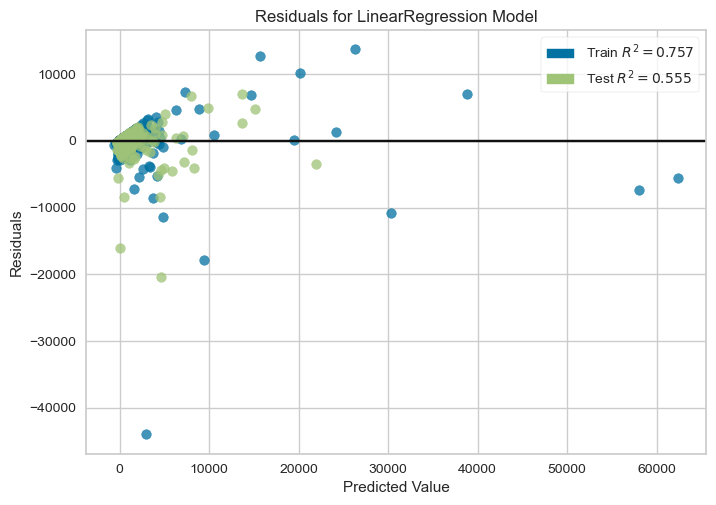

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [53]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(linear_reg_model, hist=False)

visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
visualizer.show()                

A residuals plot helps analyze the error variance of a regressor. If the points are randomly dispersed around the horizontal axis, a linear regression model is typically suitable; otherwise, a non-linear model may be better. In our case, we observe the points fairly cluster around 

Let's have a closer look to residuals distribution. 

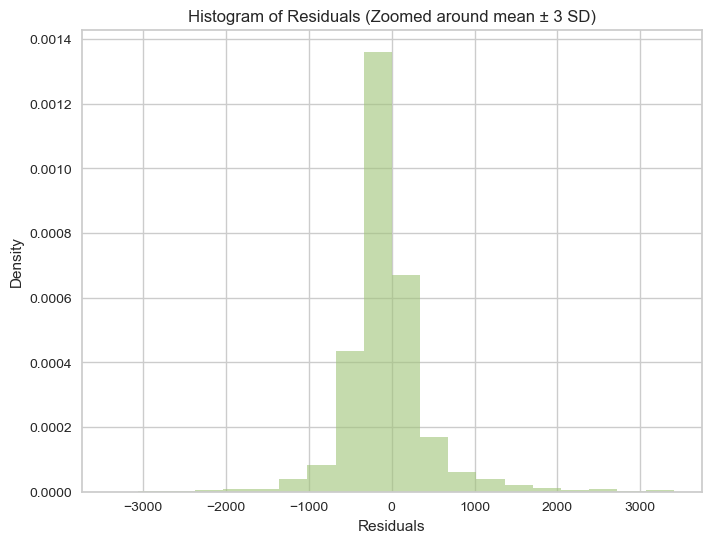

In [55]:
import numpy as np

residuals = y_test - predictions

mean_res = np.mean(residuals)
std_res = np.std(residuals)

# Define the zoom range
zoom_range = 3  # Zoom in around mean by 3 standard deviations

# Plotting residuals with zoomed-in range
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g', 
        range=(mean_res - zoom_range * std_res, mean_res + zoom_range * std_res))

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title(f'Histogram of Residuals (Zoomed around mean ± {zoom_range} SD)')

# Display the plot
plt.show()

The plot shows a roughly normal distribution of the residuals, which is a good sign. This suggests that, on average, our model predicts customer lifetime value (CLV) accurately, with residuals centered around zero and maintaining consistent variance. In simpler terms, it indicates that our model is doing a pretty good job at estimating CLV on the test data.

# Conclusion 

In [56]:
coeff

,feature,coeff
0,count_sales_M_2,109.227054
1,count_sales_M_3,-8.522712
2,count_sales_M_4,-97.087912
3,count_sales_M_5,-142.053479
4,mean_sales_M_2,0.245315
5,mean_sales_M_3,-0.517184
6,mean_sales_M_4,-0.270049
7,mean_sales_M_5,-0.123212
8,sum_sales_M_2,0.194615
9,sum_sales_M_3,0.354184


Interpretation of coefficients generated by our model: 

In the 3rd quarter of 2011, 

- Holding other features constant, an increase in number of transactions is associated with an increase in CLV by 109.23 dollars.
- Holding other features constant, an increase in average sales amount is associated with an decrease in CLV by 0.25 dollars.
- Holding other features constant, an increase in total sales amount is associated with an decrease in CLV by 0.19 dollars. 